# Supervised Anomaly Detection with Random Forest

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
logs_2018 = pd.read_csv('../logs/logs_2018.csv', index_col='datetime', parse_dates=True)
hackers_2018 = pd.read_csv(
    '../logs/hackers_2018.csv', 
    converters={'start' : np.datetime64, 'end': np.datetime64}
).assign(
    duration=lambda x: x.end - x.start, 
    start_floor=lambda x: x.start.dt.floor('h'),
    end_ceil=lambda x: x.end.dt.ceil('h')
)

## Get training and testing sets

In [3]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A pandas DataFrame
    """
    return pd.get_dummies(log[day].assign(
        failures=lambda x: np.invert(x.success)
    ).query('failures').resample('1min').agg(
        {'username':'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username':'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        A pandas Series of booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series()
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

def get_X_y(log, day, hackers):
    """
    Get the X, y data to build a model with.
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
        - hackers: The dataframe indicating when the attacks started and stopped
        
    Returns:
        X, y tuple where X is a pandas DataFrame and y is a pandas Series
    """
    X = get_X(log, day)
    y = get_y(X.reset_index().datetime, hackers)
    return X, y

In [4]:
X_train, y_train = get_X_y(logs_2018, '2018-01', hackers_2018)
X_test, y_test = get_X_y(logs_2018, '2018-02', hackers_2018)

## Random Forest
Accepting all the defaults.

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_train, y_train)

In [6]:
preds = rf.predict(X_test)
pd.Series(preds).value_counts()

False    40215
True        15
dtype: int64

## Evaluate the Model

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00     39925
        True       1.00      0.05      0.09       305

   micro avg       0.99      0.99      0.99     40230
   macro avg       1.00      0.52      0.55     40230
weighted avg       0.99      0.99      0.99     40230



Text(0.5, 0.98, 'Random Forest Classifier')

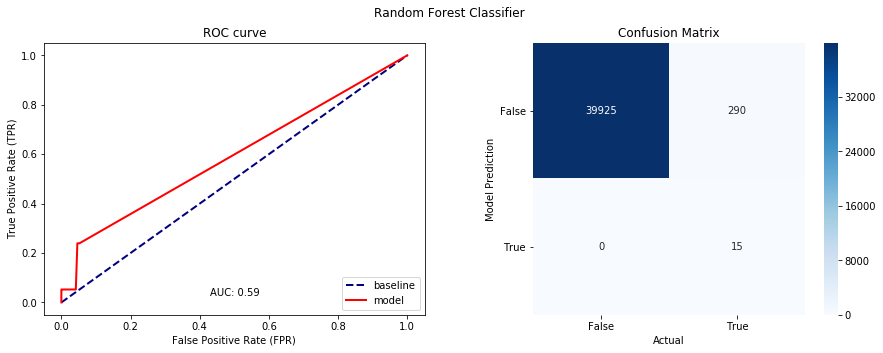

In [8]:
from utils import confusion_matrix_visual, plot_roc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_roc(y_test, rf.predict_proba(X_test)[:,1], ax=axes[0])
confusion_matrix_visual(y_test, preds, ax=axes[1], class_labels=[False, True])
plt.suptitle('Random Forest Classifier')